In this Jupyter notebook, I implement a support vector machine on the Cleveland Heart Disease dataset, which records whether patients have heart disease and associated features such as cholesterol, resting blood preasure, fasting blood sugar, and other explanatory variables of heart disease. The goal in this notebook is to accurately predict the incidence of heart disease from the predictors.

In [1]:
# import library to fetch data from UCI Machine Learning Repository
from ucimlrepo import fetch_ucirepo 

#import machine learning libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45)  

In [3]:
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets   

In [4]:
# metadata 
#print(heart_disease.metadata) 

In [5]:
# variable information 
print(heart_disease.variables) 

        name     role         type demographic  \
0        age  Feature      Integer         Age   
1        sex  Feature  Categorical         Sex   
2         cp  Feature  Categorical        None   
3   trestbps  Feature      Integer        None   
4       chol  Feature      Integer        None   
5        fbs  Feature  Categorical        None   
6    restecg  Feature  Categorical        None   
7    thalach  Feature      Integer        None   
8      exang  Feature  Categorical        None   
9    oldpeak  Feature      Integer        None   
10     slope  Feature  Categorical        None   
11        ca  Feature      Integer        None   
12      thal  Feature  Categorical        None   
13       num   Target      Integer        None   

                                          description  units missing_values  
0                                                None  years             no  
1                                                None   None             no  
2              

In [6]:
# find number of observations
len(y)

303

In [7]:
# determine number of rows (number of observations) and number of columns (number of variables)
num_rows, num_cols = X.shape
print(num_rows)
print(num_cols)

303
13


In [8]:
# drop rows in X where any column has missing values
X_cleaned = X.dropna()

In [9]:
# ensure y has the same indices as the cleaned X
y_cleaned = y.loc[X_cleaned.index]

In [10]:
# reset index for consistency
X_cleaned = X_cleaned.reset_index(drop=True)
y_cleaned = y_cleaned.reset_index(drop=True)

In [11]:
# how many observations are left after removing rows of missing values?
len(y_cleaned)

297

In [12]:
# describe the output
y_cleaned.describe()

,num
count,297.000000
mean,0.946128
std,1.234551
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,4.000000


In [13]:
# convert y: 0 stays 0, all other values become 1
y_binary = np.where(y_cleaned > 0, 1, 0)

In [14]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_binary, test_size=0.2, random_state=42)

In [15]:
# standardize the features for better SVM performance
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]  # Kernel coefficient
}

In [17]:
# create the SVM model
svm_model = SVC(kernel='rbf', random_state=42)

In [18]:
# perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train.ravel())

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [19]:
# best hyperparameters
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Best parameters: {'C': 0.1, 'gamma': 'scale'}
Best accuracy: 0.8312056737588653


In [20]:
# train the final model with the best parameters
best_svm_model = grid_search.best_estimator_

In [21]:
# make predictions
y_pred = best_svm_model.predict(X_test_scaled)

In [22]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.9000


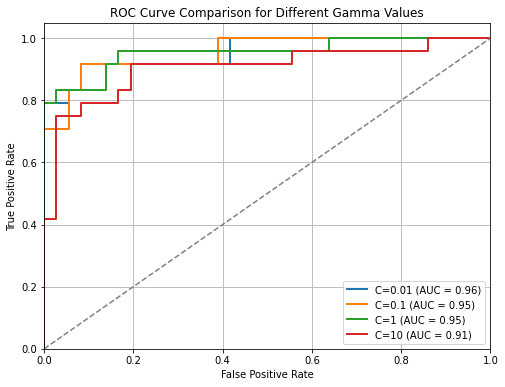

In [23]:
# different values of C to compare
C_values = [0.01, 0.1, 1, 10]

# plot ROC Curves
plt.figure(figsize=(8, 6))

for C in C_values:
    # train SVM model with different gamma values
    model = SVC(kernel='rbf', C=C, gamma='scale', probability=True, random_state=42)
    model.fit(X_train_scaled, y_train.ravel())

    # get probability scores for positive class
    y_scores = model.predict_proba(X_test_scaled)[:, 1]

    # compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    # plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'C={C} (AUC = {roc_auc:.2f})')

# plot diagonal reference line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# configure plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison for Different Gamma Values')
plt.legend(loc="lower right")
plt.grid()

# show plot
plt.show()